#### Preference-based Policy Iteration Algorithm

This is an attempt to replicate the work done by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML
import gym
from gym import wrappers
import io
import base64
import itertools
import tqdm

**State observation**:
    
    Type: Box(4)

    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

- For this project, I will describe the state of the pendulum using only the angle and angular velocity of the pole, ignoring the position and the velocity of cart.

**Actions**:

    Type: Discrete(2)
    
    Num   Action
    0     Push cart to the left
    1     Push cart to the right

In [2]:
env = gym.make('CartPole-v0')
env.reset()

print("Number of actions: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space))
print("Max. values of observation space:" + str(env.observation_space.high))
print("Min. values of observation space:" + str(env.observation_space.low))

Number of actions: 2
Observation space: Box(4,)
Max. values of observation space:[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Min. values of observation space:[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
# helper functions

def state_filter(state):
    """ only use the angle and the angular velocity of the pole to describe the state"""
    
    return state[[2,3]]


def random_action(state):
    """ return a random action: either 0 (left) or 1 (right)"""
    
    action = env.action_space.sample()  
    return action

I generate random samples $S$ in this setting by simulating a uniform random number (max 100) of uniform random actions from the initial state. If the pendulum fell within this sequence, the procedure was repeated.

In [4]:
def generate_init_states_S(seed, filter_state=True):
    """this function returns a list of randomly generated initial states from the CartPole-v0 environment """
    
    np.random.seed(seed)
    
    n_actions = np.random.randint(low=1, high=101)                # how many actions to generate
    seq_actions = np.random.randint(low=0,high=2,size=n_actions)  # random sequence of actions

    init_states_S = []   # to store initial states

    env = gym.make('CartPole-v0')
    env.reset()

    for action in seq_actions:

        state, reward, done, info = env.step(action)  # implement the actions in the random sequence
        
        if filter_state:
            init_states_S.append(state_filter(state)) # append the environment state to list (only angular velocity and angle)
        else:
            init_states_S.append(state) # all 4 state observations
            
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            env.reset()    
            
    env.close()
            
    return init_states_S

 Generate a sequence of intial states (for $S$) and display first 10

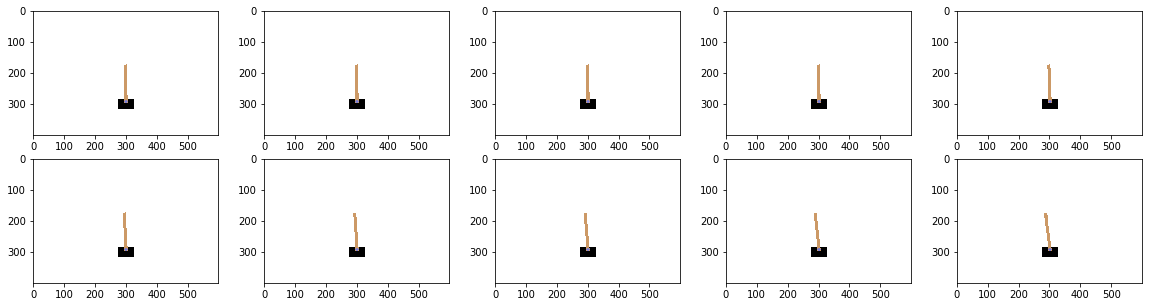

In [5]:
init_states_S = generate_init_states_S(16) # randomly generated states initial

env = gym.make('CartPole-v0') # create inv. pend environment
env = env.unwrapped           # unwrap the environment to send custom initial states
fig = plt.figure(figsize=(20,5))

for i in range(10):
    env.state = np.concatenate((np.array([0.0,0.0]),init_states_S[i])) # manually adding cart-posi & cart-velocity
    fig.add_subplot(2,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

I partition the action space to create multiple actions, because in these cases it becomes less and less likely that a unique best actions can be found. The range of the original action set {0, 1} is partitioned equidistantly into the given number of actions:

In [6]:
def partition_action_space(env,n_actions):
    """this function partitions the action space of a given environment into a given number of `n_actions`"""
    
    actions = np.arange(env.action_space.n)

    # a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space                                                                                

In [7]:
env = gym.make('CartPole-v0')

print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env,3)))
print("Partitioned into 9 actions: " + str(partition_action_space(env,9)))
print("Partitioned into 17 actions: " + str(partition_action_space(env,17)))

Original action space: 2
Partitioned into 3 actions: [-0.12215384  0.37784616  0.87784616]
Partitioned into 9 actions: [-0.09014737  0.03485263  0.15985263  0.28485263  0.40985263  0.53485263
  0.65985263  0.78485263  0.90985263]
Partitioned into 17 actions: [-0.14760155 -0.08510155 -0.02260155  0.03989845  0.10239845  0.16489845
  0.22739845  0.28989845  0.35239845  0.41489845  0.47739845  0.53989845
  0.60239845  0.66489845  0.72739845  0.78989845  0.85239845]


### Preference-based Approximate Policy Iteration algorithm

In [100]:
#####################################
### Evaluate-Preference procedure ###

### Description:
###  This is done using roll-outs
###  At every state in the initial state set, roll-outs are generated from each action for the same policy
###  Accumulated rewards from each roll-out from each action are used to generate preferences for every pair of actions
###  Generated preferences are stored in the training set; training data are used to learn the LabelRanker

### Functionality:
### - INPUTS  : starting state (s), two-actions(a_k, a_j), (current) policy (\pi), max. length of trajectoris (L)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)

### - Run this procedure for every action-pair at all initial-states

def evaluate_preference(starting_state
                        , action_1
                        , action_2
                        , policy
                        , environment_name = 'CartPole-v0'
                        , discount_fac = 0.99
                        , n_rollouts = 10
                        , max_rollout_len = 10
                       ):
    
    policy = policy              # policy to follow in roll-outs
    n_rollouts = n_rollouts      # number of roll-outs to generate
    gamma = discount_fac         # discount factor

    # state is 4 dimensional by default: if only 2 give, has to expand to 4 dimensions
    if len(starting_state) == 2:
        # manually define state-values for 'cart-position' & 'cart-velocity'
        cart_posi, cart_velo = 0,0   
        s_init = np.concatenate((np.array([cart_posi,cart_velo]),starting_state))
    else:
        s_init = starting_state
        
    # dict. to store actions
    actions = { 'one' : action_1 
              , 'two' : action_2}    

    # dict to store  rewards of roll-outs starting from each action
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dict to store average discounted return for for each action
    avg_r = {}  

    max_traj_len = max_rollout_len # maximum roll-out trajectory length

    for action_key, action_value in actions.items():

        # generate roll-outs
        for rollout in range(n_rollouts):

            env = gym.make(environment_name)
            env = env.unwrapped

            env.state = s_init  # set the starting state

            # absolute of the rounded action value is applied in case action space is partitioned
            #print(abs(round(action_value)))
            observation, reward, done, info = env.step(int(abs(round(action_value))))

            r[action_key][rollout] = reward # add the immediate reward of the action

            traj_len = 1
            while traj_len < max_traj_len and not done:

                observation, reward, done, info = env.step(policy(observation)) ### NEED TO DEFINE A POLICY

                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            env.reset()
            env.close()

        # calculate average discounted return 
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    # return preference info. to generate training data
    if avg_r['one'] > avg_r['two']:
        return {'state': s_init[[2,3]] if len(s_init)>2 else s_init # only use the angel and velocity of pendulum for state
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}
#     elif avg_r['two'] > avg_r['one']:
#         return {'state': s_init[[2,3]] if len(s_init)>2 else s_init  # only use the angel and velocity of pendulum for state
#                , 'a_k_prefered_a_j' : [actions['two'],actions['one']]
#                , 'preference_label' : 1}
    else:
        return {'state': s_init[[2,3]] if len(s_init)>2 else s_init # only use the angel and velocity of pendulum for state
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}

In [108]:
evaluate_preference(env.reset(),0.3,0.6,random_action)

{'state': array([0.04932088, 0.04057652]),
 'a_j': 0.3,
 'a_k': 0.6,
 'preference_label': 0}

In [201]:
###################################################
### Preference-Based Policy Iteration Algorithm ###

### Functionality:
### - INPUTS  : sample states (s'), initial (random) policy (\pi0), max. num. of policy iterations (p)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)


# initialize environment
env = gym.make('CartPole-v0')

# initial random policy
policy_init = random_action
policy = policy_init

# sample states
sample_states = generate_init_states_S(seed = 16) # randomly generated states initial

# maximum number of policy iterations
max_iterr = 1 # increase this after writing the LabelRanker

# action space to consider
act_space = partition_action_space(env,3)

# generate action-pairs (per each)
act_pairs = list(itertools.combinations(act_space,2))

# place-holder for training data
train_data = []

iterr = 0

pbar = tqdm.tqdm(total=max_iterr)

while iterr < max_iterr:
    
    # place-holder for training data
    #train_data = [] # uncomment this after adding LabelRanker

    
    for state in sample_states:
        
        for action_pair in act_pairs:
            preference_out = evaluate_preference(state, action_pair[0], action_pair[1], policy)
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
            
    pbar.update(1)
    iterr += 1
    
    
pbar.close()

### Train LaberRanker using train-data
### Create new policy using LabeRanker
### Re-run loop with new policy

        
        
    




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


### `LABEL-RANKER` Model training Experiment

In [271]:
train_df = pd.DataFrame(train_data)

In [272]:
train_df.head(3)

,state,a_j,a_k,preference_label
0,"[-0.04042570338131652, 0.2768141014688637]",-0.122154,0.377846,0
1,"[-0.04042570338131652, 0.2768141014688637]",-0.122154,0.877846,0
2,"[-0.04042570338131652, 0.2768141014688637]",0.377846,0.877846,0


In [273]:
# create a key for state
train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

In [275]:
# drop all states which does not have any preferred action
temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'right')

In [276]:
# create a single column with the set of actions executed per state
temp_df1 = train_df.groupby('state_key')['a_j'].unique().reset_index()
temp_df2 = train_df.groupby('state_key')['a_k'].unique().reset_index()
temp_df3 = temp_df1.merge(right=temp_df2
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'inner')
temp_df3.loc[:,'unique_acts'] = temp_df3.apply(lambda row: set(list(row['a_j']) + list(row['a_k'])) ,axis=1)

In [277]:
temp_df3.head(3)

,state_key,a_j,a_k,unique_acts
0,-0.007119426465262891_0.010133984961571807,"[-0.12215383778081441, 0.3778461622191856]","[0.3778461622191856, 0.8778461622191855]","{-0.12215383778081441, 0.8778461622191855, 0.3..."
1,-0.035456221985432065_-0.331823583123806,"[-0.12215383778081441, 0.3778461622191856]","[0.3778461622191856, 0.8778461622191855]","{-0.12215383778081441, 0.8778461622191855, 0.3..."
2,-0.042092693647908186_-0.635473455421564,"[-0.12215383778081441, 0.3778461622191856]","[0.3778461622191856, 0.8778461622191855]","{-0.12215383778081441, 0.8778461622191855, 0.3..."


In [278]:
# add the unique-action column to train dataset
train_df = train_df.merge(right = temp_df3.loc[:,['state_key', 'unique_acts']]
              , right_on =  'state_key'
              , left_on = 'state_key'
              , how = 'left')

In [279]:
train_df.loc[train_df.state_key == '-0.054802162756339465_-0.9411095238977125']

,state,a_j,a_k,preference_label,state_key,unique_acts
6,"[-0.054802162756339465, -0.9411095238977125]",-0.122154,0.377846,1,-0.054802162756339465_-0.9411095238977125,"{-0.12215383778081441, 0.8778461622191855, 0.3..."
7,"[-0.054802162756339465, -0.9411095238977125]",-0.122154,0.877846,1,-0.054802162756339465_-0.9411095238977125,"{-0.12215383778081441, 0.8778461622191855, 0.3..."
8,"[-0.054802162756339465, -0.9411095238977125]",0.377846,0.877846,1,-0.054802162756339465_-0.9411095238977125,"{-0.12215383778081441, 0.8778461622191855, 0.3..."


In [280]:
# create a 'prefered-action' value for each state
train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

In [282]:
train_df.head()

,state,a_j,a_k,preference_label,state_key,unique_acts,prefered_action
0,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.377846,0,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",0.377846
1,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.877846,1,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",-0.122154
2,"[-0.035456221985432065, -0.331823583123806]",0.377846,0.877846,1,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",0.377846
3,"[-0.042092693647908186, -0.635473455421564]",-0.122154,0.377846,0,-0.042092693647908186_-0.635473455421564,"{-0.12215383778081441, 0.8778461622191855, 0.3...",0.377846
4,"[-0.042092693647908186, -0.635473455421564]",-0.122154,0.877846,1,-0.042092693647908186_-0.635473455421564,"{-0.12215383778081441, 0.8778461622191855, 0.3...",-0.122154


In [323]:
action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
action_preference_counts.replace(np.nan,0,inplace=True)
action_preference_counts.head()

prefered_action,-0.122154,0.377846,0.877846
state_key,,,
-0.007119426465262891_0.010133984961571807,1.0,1.0,1.0
-0.035456221985432065_-0.331823583123806,1.0,2.0,0.0
-0.042092693647908186_-0.635473455421564,1.0,2.0,0.0
-0.054802162756339465_-0.9411095238977125,2.0,1.0,0.0
-0.07362435323429371_-0.6661375648946086,2.0,1.0,0.0


In [324]:
### create training labels for each state
action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()

In [329]:
action_preference_counts.head()

prefered_action,-0.12215383778081441,0.3778461622191856,0.8778461622191855,preference_label_vector
state_key,,,,
-0.007119426465262891_0.010133984961571807,1.0,1.0,1.0,"[1.0, 1.0, 1.0]"
-0.035456221985432065_-0.331823583123806,1.0,2.0,0.0,"[1.0, 2.0, 0.0]"
-0.042092693647908186_-0.635473455421564,1.0,2.0,0.0,"[1.0, 2.0, 0.0]"
-0.054802162756339465_-0.9411095238977125,2.0,1.0,0.0,"[2.0, 1.0, 0.0]"
-0.07362435323429371_-0.6661375648946086,2.0,1.0,0.0,"[2.0, 1.0, 0.0]"


In [331]:
# add preference label data to training dataset
train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                          , right_index= True
                          , left_on = 'state_key'
                          , how = 'left')

In [334]:
# create the reduced training dataset
train_df_reduced = train_df.loc[:,['state', 'state_key', 'unique_acts', 'preference_label_vector']]

In [356]:
train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
train_df_reduced

,state,state_key,unique_acts,preference_label_vector
0,"[-0.035456221985432065, -0.331823583123806]",-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
3,"[-0.042092693647908186, -0.635473455421564]",-0.042092693647908186_-0.635473455421564,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
6,"[-0.054802162756339465, -0.9411095238977125]",-0.054802162756339465_-0.9411095238977125,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[2.0, 1.0, 0.0]"
9,"[-0.07362435323429371, -0.6661375648946086]",-0.07362435323429371_-0.6661375648946086,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[2.0, 1.0, 0.0]"
12,"[-0.08694710453218589, -0.9810636811130726]",-0.08694710453218589_-0.9810636811130726,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
15,"[-0.10656837815444734, -1.29974162808073]",-0.10656837815444734_-1.29974162808073,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
18,"[-0.13256321071606192, -1.0422308309883974]",-0.13256321071606192_-1.0422308309883974,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[2.0, 1.0, 0.0]"
21,"[-0.15340782733582986, -1.373417153619405]",-0.15340782733582986_-1.373417153619405,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
24,"[0.04629876102299209, 1.1981952421426543]",0.04629876102299209_1.1981952421426543,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 0.0, 2.0]"
27,"[0.07026266586584518, 1.5050219120869652]",0.07026266586584518_1.5050219120869652,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 0.0, 2.0]"


In [ ]:
# above dataset has - state + list of actions + # preferences made for each action (at state) --> each row

In [85]:
train_out_labels = torch.tensor(train_df.preference_label.values.tolist())
#train_out_labels =[ torch.tensor(label) for label in train_df.preference_label.values.tolist()]

In [75]:
class Model(nn.Module):

    def __init__(self, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        input_size = num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_numerical):
        x_numerical = self.batch_norm_num(x_numerical)
        x = self.layers(x_numerical)
        return x

In [89]:
model = Model(train_samples.shape[1], 2, [200,100,50], p=0.4)

In [90]:
print(model)

Model(
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [91]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
epochs = 300
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(train_samples.float())
    single_loss = loss_function(y_pred, train_out_labels)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.86207616
epoch:  26 loss: 0.39926690
epoch:  51 loss: 0.33612713
epoch:  76 loss: 0.31516284
epoch: 101 loss: 0.30613711
epoch: 126 loss: 0.29426527
epoch: 151 loss: 0.28912571
epoch: 176 loss: 0.27681562
epoch: 201 loss: 0.28387845
epoch: 226 loss: 0.28130651
epoch: 251 loss: 0.27547008
epoch: 276 loss: 0.27505055
epoch: 300 loss: 0.2682622969


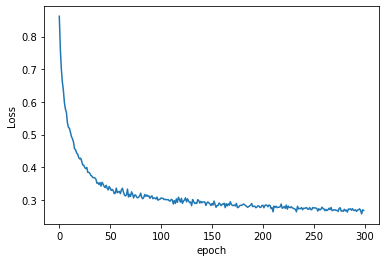

In [94]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [ ]:
### Label Ranker ###

# To-be completed after creating a training-dataset


In [196]:
c_posi, c_velo = 0,0 # manually define state-values for 'cart-position' & 'cart-velocity'
np.concatenate((np.array([c_posi,c_velo]),sample_states[0]))


array([0.        , 0.        , 0.00736531, 0.26078459])

In [203]:
env = gym.make('CartPole-v0')
c_posi, c_velo = 0,0 # manually define state-values for 'cart-position' & 'cart-velocity'
env = env.unwrapped
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
env.state = np.concatenate((np.array([c_posi,c_velo]),sample_states[0]))
for _ in range(100):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

In [204]:
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

## APPENDIX

### Visualize episode

In [12]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

episode 19 finished after 8 timesteps. Total reward: 8.0


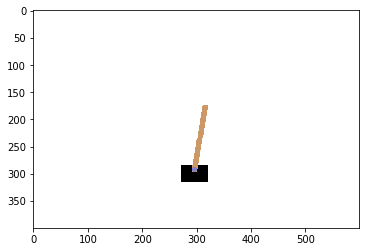

In [5]:
nb_episodes = 20
nb_timesteps = 100
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for episode in range(nb_episodes):  # iterate over the episodes
    state = env.reset()             # initialise the environment
    rewards = []
    
    for t in range(nb_timesteps):    # iterate over time steps
        #env.render()                 # display the environment
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, info = env.step(0)  # implement the action chosen by the policy
        rewards.append(reward)      # add 1 to the rewards list
        
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            cumulative_reward = sum(rewards)
            print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward))  
            break
    
env.close()